In [10]:
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np

# Masterdata

In [11]:
__tires_perc_problem__ = .30
__fuel_amount_start__ = 100
__tire_change_sec__ = 3
__l_per_sec__ = 5

overall_rounds = 51
tire_per_round = 12
fuel_per_round = 10
rounds_fuel = math.floor(100 / fuel_per_round)
rounds_tires = math.floor(100 / tire_per_round)
round_duration_sec = 51
secs_lost_with_tires_low_per_round = 5
fuel_safety = 4
strats = ['avoid_low_tire', 'minimize_low_tire', 'least_stops']


## Calculate some constants

In [13]:
rounds_without_tire_problem = rounds_tires * (1- __tires_perc_problem__)


# Ceiled and floored rounds
rounds_without_tire_problem_floored = math.floor(rounds_without_tire_problem)
rounds_without_tire_problem_ceiled = math.ceil(rounds_without_tire_problem)

# Stints overall needed
stints_needed = overall_rounds /  rounds_without_tire_problem

print(f"Rounds per stint: {rounds_tires} - {rounds_without_tire_problem_floored}/{rounds_without_tire_problem_ceiled} in {stints_needed} sints")

Rounds per stint: 8 - 5/6 in 9.107142857142858 sints


## Helper functions for pitstop logic

In [15]:
def doPitStop(fuel_percent, tire_percent, last_stop_round, df, reason):
    
    print(f"PITSPOT in round: {current_round} (last stop in: {last_stop_round}) due to __{reason}__")
    
    tire_percent = 100
    
    rounds_left = overall_rounds - current_round
    
    # either 100 percent or simply for how many rounds are left
    fuel_percent = max(min((rounds_left * fuel_per_round) + fuel_safety, 100), fuel_percent)
        
    df.append(dict(Task=f"Stint {len(df) + 1}", start=last_stop_round, finish=current_round))
    
    print(f"PITSPOT done, tire: {tire_percent}, fuel: {fuel_percent} - nr.: {len(df) + 1}")
    
    
    return fuel_percent, tire_percent, current_round

In [109]:
def makePlot(df):
    num_tick_labels = np.linspace(start = 0, stop = 51, num = 52, dtype = int)
    date_ticks = [convert_to_datetime(x) for x in num_tick_labels]

    fig = ff.create_gantt(df)
    fig.layout.xaxis.update({
        'tickvals' : date_ticks,
        'ticktext' : num_tick_labels
    })

    fig.show()

## Simulation

In [16]:
splits = []

for i, strat in enumerate(strats):
    
    df = []
   
    current_round = 1
    fuel_percent = 100
    tire_percent = 100
    last_stop_round = 1
    
    print(f"##################")
    print(f"Simulating with strat: {strat}")
    
    while current_round <= overall_rounds:
        
        if current_round == 1:
            print(f"Current round: {current_round} - fuel: {fuel_percent}/ tire: {tire_percent}")
            current_round+=1
            pass
        
        fuel_percent -= fuel_per_round
        tire_percent -= tire_per_round
        
        print(f"Current round: {current_round} - fuel: {fuel_percent}/ tire: {tire_percent}")
        
        if fuel_percent < fuel_per_round:
            fuel_percent, tire_percent, last_stop_round = doPitStop(fuel_percent, tire_percent, last_stop_round, df, 'FUEL')

        if strat == 'avoid_low_tire':
            # cant do another round without getting into red zone
            if tire_percent < (__tires_perc_problem__) * 100 + tire_per_round:
                fuel_percent, tire_percent, last_stop_round = doPitStop(fuel_percent, tire_percent, last_stop_round, df, 'TIRE')
        elif strat == 'minimize_low_tire':
            # this round with red tires will be done, then pitted
            if tire_percent < (__tires_perc_problem__) * 100:
                fuel_percent, tire_percent, last_stop_round = doPitStop(fuel_percent, tire_percent, last_stop_round, df, 'TIRE')
        elif strat == 'least_stops':
            # This is the last round which can be done before tires breaking
            if tire_percent < tire_per_round * 1:
                fuel_percent, tire_percent, last_stop_round = doPitStop(fuel_percent, tire_percent, last_stop_round, df, 'TIRE')
                
        
        current_round+=1
        
        if current_round == overall_rounds + 1:
            print("FINISH")
            
            #makePlot(df)
    

##################
Simulating with strat: avoid_low_tire
Current round: 1 - fuel: 100/ tire: 100
Current round: 2 - fuel: 90/ tire: 88
Current round: 3 - fuel: 80/ tire: 76
Current round: 4 - fuel: 70/ tire: 64
Current round: 5 - fuel: 60/ tire: 52
Current round: 6 - fuel: 50/ tire: 40
PITSPOT in round: 6 (last stop in: 1) due to __TIRE__
PITSPOT done, tire: 100, fuel: 100 - nr.: 2
Current round: 7 - fuel: 90/ tire: 88
Current round: 8 - fuel: 80/ tire: 76
Current round: 9 - fuel: 70/ tire: 64
Current round: 10 - fuel: 60/ tire: 52
Current round: 11 - fuel: 50/ tire: 40
PITSPOT in round: 11 (last stop in: 6) due to __TIRE__
PITSPOT done, tire: 100, fuel: 100 - nr.: 3
Current round: 12 - fuel: 90/ tire: 88
Current round: 13 - fuel: 80/ tire: 76
Current round: 14 - fuel: 70/ tire: 64
Current round: 15 - fuel: 60/ tire: 52
Current round: 16 - fuel: 50/ tire: 40
PITSPOT in round: 16 (last stop in: 11) due to __TIRE__
PITSPOT done, tire: 100, fuel: 100 - nr.: 4
Current round: 17 - fuel: 90/

In [80]:
splits = []
rounds_driven = 0
start_fuel = 100

while rounds_driven <= overall_rounds:
    ############
    # ROUND CALC #
    ############
    splits.append(dict(Task=f"{i} Stint", Start=start, Finish=end, split_type="stint", rounds_driven=rounds_driven))
    
    df = [
        
        dict(Task="Job A", Start=convert_to_datetime(0), Finish=convert_to_datetime(4)),
        dict(Task="Job B", Start=convert_to_datetime(3), Finish=convert_to_datetime(6)),
        dict(Task="Job C", Start=convert_to_datetime(6), Finish=convert_to_datetime(10))
    ]

    num_tick_labels = np.linspace(start = 0, stop = 10, num = 11, dtype = int)
    date_ticks = [convert_to_datetime(x) for x in num_tick_labels]

   
    
    ############
    ## BOX CALC ##
    ############
    
    # TODO change "rounds_without_tire_problem" if different strats are applied
    fuel_charging_time = ((rounds_without_tire_problem / rounds_fuel) * 100) / __l_per_sec__
    
    # If fueling takes longer than changing tyres, this can be done in parallel so doesnt need to be summed up
    if fuel_charging_time > __tire_change_sec__:
        stop_time = fuel_charging_time
    else:
        stop_time = __tire_change_sec__
    
    start =  f"{datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%fZ').isoformat()[:-3]}Z"
    end = f"{(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%fZ') +  timedelta(seconds=stop_time)).isoformat()[:-3]}Z"
        
    print(start)
    print(end)
    print(fuel_charging_time)
        
    splits.append(dict(Task=f"{i} Stop", Start=start, Finish=end, split_type="box_stop"))
                  
    i+=1

NameError: name 'start' is not defined

In [186]:
df

[{'Task': 'Stint 1', 'start': 1, 'finish': 9},
 {'Task': 'Stint 2', 'start': 9, 'finish': 17},
 {'Task': 'Stint 3', 'start': 17, 'finish': 25},
 {'Task': 'Stint 4', 'start': 25, 'finish': 33},
 {'Task': 'Stint 5', 'start': 33, 'finish': 41},
 {'Task': 'Stint 6', 'start': 41, 'finish': 49},
 {'Task': 'Stint 7', 'start': 49, 'finish': 51}]

In [8]:
import sys
print(sys.version)
sys.path
sys.executable

!"c:\users\jakob engl\appdata\local\programs\python\python38\python.exe" -m pip install matplotlib



3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
  Using cached https://files.pythonhosted.org/packages/0f/84/2b2d869816512ddfef46a8c130782ca770009d920e295e3805bd6174014a/matplotlib-3.4.3-cp38-cp38-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ff/fb/506890622e1dcddaa3b215a6cef70d72c4e248feed0045eb52904d1ef80b/Pillow-8.4.0-cp38-cp38-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/30/17/5474c0fcd670f1bb2204218bf3f444e6012a97f774336022612320ab4ea4/kiwisolver-1.3.2-cp38-cp38-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [20]:
df

[{'Task': 'Stint 1', 'start': 1, 'finish': 9},
 {'Task': 'Stint 2', 'start': 9, 'finish': 17},
 {'Task': 'Stint 3', 'start': 17, 'finish': 25},
 {'Task': 'Stint 4', 'start': 25, 'finish': 33},
 {'Task': 'Stint 5', 'start': 33, 'finish': 41},
 {'Task': 'Stint 6', 'start': 41, 'finish': 49},
 {'Task': 'Stint 7', 'start': 49, 'finish': 51}]

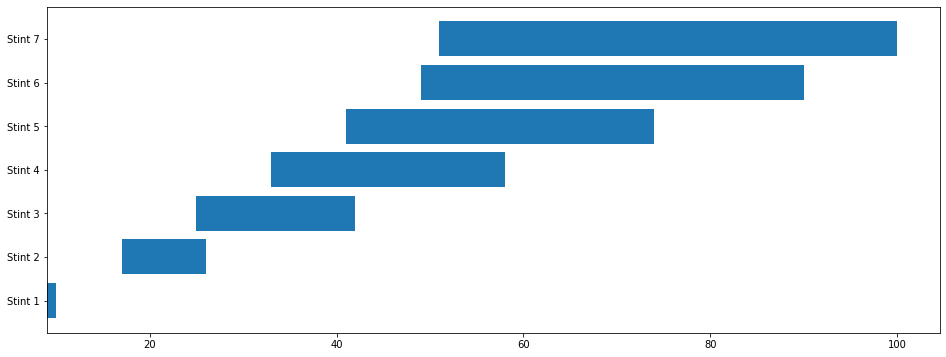

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plotDf = pd.DataFrame(df)


fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(plotDf.Task, plotDf.start, left=plotDf.finish)
plt.show()



In [175]:
import plotly.figure_factory as ff
from datetime import datetime
import numpy as np

def convert_to_datetime(x):
    return datetime.fromtimestamp(31536000+x*24*3600).strftime("%Y-%d-%m")

df = [dict(Task="Job A", Start=convert_to_datetime(0), Finish=convert_to_datetime(4)),
      dict(Task="Job B", Start=convert_to_datetime(3), Finish=convert_to_datetime(5)),
      dict(Task="Job C", Start=convert_to_datetime(5), Finish=convert_to_datetime(7)),
      dict(Task="Job D", Start=convert_to_datetime(6), Finish=convert_to_datetime(51))]

num_tick_labels = np.linspace(start = 0, stop = 15, num = 16, dtype = int)
date_ticks = [convert_to_datetime(x) for x in num_tick_labels]

fig = ff.create_gantt(df)
fig.layout.xaxis.update({
        'tickvals' : date_ticks,
        'ticktext' : num_tick_labels
        })

fig.show()

In [79]:
df = pd.DataFrame(splits)

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", color="split_type", hover_data={'rounds_driven':True})
#fig.update_yaxes(autorange="reversed")


fig.add_vline(x=end, line_width=3, line_dash="dash", line_color="green")




fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of [] but received: Task